<h1>City of Toronto Sidewalk Inventory</h1>

The [Toronto Sidewalk Inventory](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=3cdcfb292f426410VgnVCM10000071d60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD) is a geospatial dataset that provides the location of sidewalks along transportation corridors within the city limits of Toronto.  The data, captured using aerial photography ("orthoimagery") in spring of 2015, is used by city planners and other interested parties on determining where to build new sidewalks.  The digital dataset is built on top of the [Toronto "centreline" (roadway) dataset](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=9acb5f9cd70bb210VgnVCM1000003dd60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD), with some additional entries for pedestrian paths not associated with roads.

Sean Marshall used the dataset to generate [this interactive map](https://seanmarshall.ca/2016/03/16/where-the-sidewalk-ends/) of sidewalk availability, and commented on walkability plans.  I only have time to play with the dataset for a short time, so let's see if I can reproduce his work, and perhaps see if there's any correlation between the median income within a ward (Toronto electoral subdivision) and sidewalk availability.

In [1]:
# Preamble

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import cartopy.crs as ccrs

import geopandas as gpd
from cartopy.io.shapereader import Reader
import pyproj
import shapely.geometry as sgeo
import fiona

%matplotlib notebook

<h1>Dataset Preparation</h1>

To associate missing sidewalks to wards, I need to map roads to the [wards dataset](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=b1533f0aacaaa210VgnVCM1000006cd60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD). I'll also be interested in [neighbourhood](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=04b489fe9c18b210VgnVCM1000003dd60f89RCRD) and [zoning boundaries](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=5a9923e69b4a6410VgnVCM10000071d60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD).  Another meetup member, Richard Hydomako, [uploaded a gist](https://gist.github.com/rhydomako/e02bea6780e96000cccff5fcf193fe2f) that does exactly that.  We follow his lead in creating such a file.

In [2]:
# Modification of Richard Hydomako's code to create a shapefile that includes ward, neighbourhood
# and zoning boundary information.

# Make dicts of ward names and shapes given number
ward_bds = {}
ward_names = {}

# create a lookup dict where the key is the ward name, and the value is the ward geometry
with fiona.collection("./data/icitw_wgs84.shp",'r') as shp_input:
    for record in shp_input:
        ward_bds[record['properties']['SCODE_NAME']] = sgeo.shape(record['geometry'])
        ward_names[record['properties']['SCODE_NAME']] = record['properties']['NAME'].split(" (")[0]
        
# Make dict of neighbourhood bounds
neigh_bds = {}

# create a lookup dict where the key is the ward name, and the value is the ward geometry
with fiona.collection("./data/NEIGHBORHOODS_WGS84.shp",'r') as shp_input:
    for i, record in enumerate(shp_input):
        neigh_bds[i] = [sgeo.shape(record['geometry']), 
                       record['properties']["AREA_NAME"]]
        
# Make dict of zone and shapes
zone_bds = {}

# create a lookup dict where the key is the ward name, and the value is the ward geometry
with fiona.collection("./data/ZONING_ZONE_CATAGORIES_WGS84.shp",'r') as shp_input:
    for record in shp_input:
        zone_bds[record['properties']['OBJECTID']] = [sgeo.shape(record['geometry']), 
                                                      record['properties']["ZN_ZONE"]]

In [75]:
# http://preshing.com/20110920/the-python-with-statement-by-example/
%%time
with fiona.collection('./data/Sidewalk_Inventory_wgs84.shp','r') as shp_input:
    
    # Copy the old file's schema and include the ward in the properties
    schema = shp_input.schema.copy()
    schema['properties']['ward'] = 'int'
    schema['properties']['ward_name'] = 'str'
    schema['properties']['neighbourhood'] = 'str'
    schema['properties']['zone'] = 'str'
    
    # Coordinate system is for some reason in NAD27.  Have to convert. 
    nad27 = pyproj.Proj(projparams=shp_input.crs)

    with fiona.collection('./data/Sidewalk_Inventory_wgs84_wards.shp', 'w', 'ESRI Shapefile', schema=schema, 
                          crs={'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}) as output:
    
        # Loop through Sidewalk_Inventory entries
        for i, record in enumerate(shp_input):
            
            #geometry = sgeo.shape(record['geometry'])
            #properties = record['properties']
            #ward = None
            #ward_name = None
            
            # Convert geometry from NAD27 to lat/long
            coords = np.array(record["geometry"]["coordinates"])
            # If coordinates are disjoint
            if coords.ndim != 2:
                coords = [np.array(item) for item in record["geometry"]["coordinates"]]
                longlat = [np.array(nad27(item[:,0], item[:,1], inverse=True)).T for item in coords]
                geometry = sgeo.MultiLineString(longlat)
            else:
                longlat = np.array(nad27(coords[:,0], coords[:,1], inverse=True)).T
                geometry = sgeo.LineString(longlat)

            properties = record['properties']
            ward = None
            ward_name = None
            neighbourhood = None
            zone = None
            
            # Spatial joins - Richard mentioned this has its own biases, but I can't think of a better
            # way to do this without more data
            for num, geo in ward_bds.items():
                if geo.contains(geometry.centroid): #line segment centroid is in the ward boundry
                    ward = num
                    ward_name = ward_names[num]
                    break
            properties['ward'] = ward
            properties['ward_name'] = ward_name

            for num, geo in neigh_bds.items():
                if geo[0].contains(geometry.centroid): 
                    neighbourhood = geo[1]
                    break
            properties['neighbourhood'] = neighbourhood
            
            for num, geo in zone_bds.items():
                if geo[0].contains(geometry.centroid): 
                    zone = geo[1]
                    break
            properties['zone'] = zone
            
            #write to the new shapefile
            output.write({
                'properties': properties,
                'geometry': sgeo.mapping(geometry)
            })

Load this new file in and do some further data cleaning.  This text is copied from the Readme.doc included with the inventory zip, and explains the terminology below:

- Pending (code 6) segments indicate areas which are under new development (construction) and may or may not include a sidewalk after the observed development is completed.

- Walkways (code 11) within the inventory are pedestrian only paths that typically connect two roadways and are part of the official City centerline data.

- Pathways (code 12): Pathways are segments that are pedestrian paths of interest observed within the aerial imagery but not documented within the official City centreline data. These unofficial paths may not be maintained or owned by the City. Examples of pathways include walkways, recreational trails and desire lines which may not be paved.

- Sidewalks are not a required component of laneways, however, where sidewalks are present on laneways codes 1 to 7 are used to indicate sidewalk presence. Otherwise code 10 is used to indicate laneways without sidewalks.

The file also notes that code 13 or "not applicable" segments are either roadways such as expressways where sidewalks are not built, or non-road features such as railways and shorelines.

In [3]:
sidewalk = gpd.read_file('./data/Sidewalk_Inventory_wgs84_wards.shp')

# A la Richard Hydomako's code, determine sidewalk status
def identify_sidewalk(x):
    if x == 7:
        return "both"
    elif x in [1, 2, 4, 5]:
        return "one"
    elif x == 3:
        return "no"
    elif x == 6:
        return "being built"
    elif x == 10:
        return "laneway"
    elif x in [11, 12]:
        return "path"
    
    return None

# Define road status colours
plot_colours = {"both": "#00BB36", "one": "#F4D110", "no": "#F41010", "being built": "#24FAFA",
                "laneway": "#5D5D5D", "path": "#99B6FF", "trail": "#2362FF"}

def set_plot_colours(x):
    if x:
        return plot_colours[x]
    return None

sidewalk["Sidewalk Status"] = sidewalk["SDWLK_Code"].apply(identify_sidewalk)
sidewalk["Sidewalk Colour"] = sidewalk["Sidewalk Status"].apply(set_plot_colours)

In [4]:
# There are a few instances where sidewalk["Sidewalk Status"] is null, but sidewalk["SDWLK_DESC"] isn't
# "not applicable".  Let's find where.

for item in sidewalk["SDWLK_DESC"].unique():
    ws = np.where(sidewalk["Sidewalk Status"].isnull() & (sidewalk["SDWLK_DESC"] == item))[0]
    if ws.size > 0:
        print(item)

Not applicable
Recreational Trail
Not applicable; may be outdated


In [5]:
# 'Not applicable' and 'may be outdated' can be left as is; but let's change all the null sidewalk statuses
# under "recreational trail" to "trail", giving it a similar colour to "path", which includes "Desire Line/Goat Path"
# (Brian Nguyen of the City of Toronto Transportation Services noted the latter means a dirt path dug out by 
# human foot traffic).

rectrails = (sidewalk["Sidewalk Status"].isnull() & \
             (sidewalk["SDWLK_DESC"] == "Recreational Trail")).copy()
sidewalk.loc[rectrails, "Sidewalk Status"] = "trail"
sidewalk.loc[rectrails, "Sidewalk Colour"] = plot_colours["trail"]

<h1>Sidewalk Availability Plot</h1>

Let's now replicate the Marshall plot of sidewalk availability throughout Toronto.  This gives us a global overview of which sections of Toronto tend to lack sidewalk coverage.  Following Marshall's plot, we also overplot [former municipal boundaries](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=a4720ad4e4030410VgnVCM10000071d60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD) to better orient ourselves geographically.

<IPython.core.display.Javascript object>


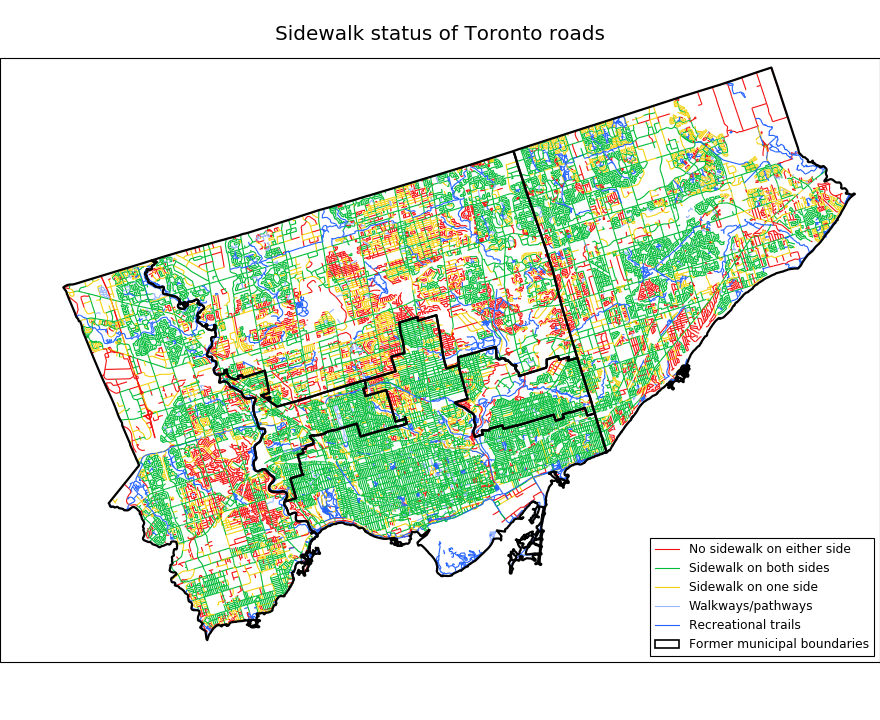

/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f709a4af938> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f7099fd01a8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


In [6]:
# Based off of the last bit of Elliott Sales de Andrade's cartopy tutorial
# https://uoftcoders.github.io/studyGroup/lessons/python/cartography/lesson/

# Read in old municipal boundaries
wb = Reader("./data/citygcs_former_municipality_wgs84.shp")

# Figure properties
standard_parallels = (49, 77)
central_longitude = -79.3832 #43.6532° N, 79.3832° W   # -(91 + 52 / 60)
length = 11; height = 9;

# Prep figure
fig = plt.figure(figsize=(length,height))
ax = fig.add_axes([0., 0., 1., 1.], projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                                      standard_parallels=standard_parallels))
ax.set_extent([-79.68, -79.1, 43.57, 43.86])
#ax.gridlines()

wanted_entries = (sidewalk["Sidewalk Status"] == "no") | (sidewalk["Sidewalk Status"] == "both") | \
                (sidewalk["Sidewalk Status"] == "one") | (sidewalk["Sidewalk Status"] == "path") | \
                (sidewalk["Sidewalk Status"] == "trail")
ax.add_geometries(sidewalk.loc[wanted_entries, "geometry"], crs=ccrs.Geodetic(), lw=1, 
                  edgecolor=sidewalk.loc[wanted_entries, "Sidewalk Colour"], facecolor='none');

# wb.geometries iterates over shapely.geometry.multipolygon.MultiPolygon
ax.add_geometries(wb.geometries(), crs=ccrs.Geodetic(), lw=2, edgecolor='k', facecolor='none');
ax.set_axis_off()
ax.set_title("Sidewalk status of Toronto roads", fontsize=18, y=1.02);

line_artists = (mlines.Line2D([],[], color=plot_colours["no"], marker='None', ls="-"),
                mlines.Line2D([],[], color=plot_colours["both"], marker='None', ls="-"),
                mlines.Line2D([],[], color=plot_colours["one"], marker='None', ls="-"),
                mlines.Line2D([],[], color=plot_colours["path"], marker='None', ls="-"),
                mlines.Line2D([],[], color=plot_colours["trail"], marker='None', ls="-"),
                plt.Rectangle((0, 0), 1, 1, fc="none", ec="k", lw=1.5))
leg = ax.legend(line_artists, ("No sidewalk on either side", "Sidewalk on both sides", "Sidewalk on one side",
                "Walkways/pathways", "Recreational trails", "Former municipal boundaries"), loc=4, fontsize=11, numpoints = 1, markerscale=1)

# A whole bunch of settings to try to make the figure borders white, but none work!
fig.savefig("../docs/images/toronto_sidewalks.png", dpi=200, facecolor='w', edgecolor='w', 
            transparent=False, frameon=True)

<h1>Correlating Sidewalk Availability with Zoning and Income</h1>

I naively hypothesize that sidewalks are lacking in areas that 

- Aren't residential neighbourhoods,
- Are in lower-income areas that are potentially underserved by by the city, or
- Are in low population density areas (which therefore aren't as high priority for development)

We can account for the former by examining the correlation between zoning and sidewalk availability, and the latter by comparing median income in wards with availability.  I had originally also wanted to consider house price against availability using data from the [Globe and Mail](http://www.theglobeandmail.com/real-estate/exclusive-how-much-are-homes-in-toronto-neighbourhoods/article24060725/).  Unfortunately, the G&M neighbourhoods don't correspond with those given by the city (and it would be difficult to map one to the other), and housing is not subdivided into detached homes, condos, townhouses and apartments.  Let's stick with using income.

I'll separate income and zoning analyses, since they don't have the same geographic discretization (zones don't line up with wards), and many areas even near downtown don't have zones.

<h2>Zoning</h2>

From the [zoning bylaw map](http://map.toronto.ca/maps/map.jsp?app=ZBL_CONSULT) on the City of Toronto website, the zone codes are:

- R - residential
- RD - residential detached
- RS - residential semi detached
- RT - residential townhouse
- RM - residential multiple dwelling
- RA - residential apartment
- O - open space
- ON - open space natural
- OR - open space recreation
- OG - open space golf course
- OM - open space marina
- OC - open space cemetery
- UT - utility and transportation
- CL - commercial local
- CR - commercial residential
- CRE - commercial residential employment
- EL - employment light industrial
- E - employment industrial
- EH - employment heavy industrial
- EO - employment industrial office
- I - institutional general
- IH - institutional hospital
- IE - institutional education
- IS - institutional school
- IPW - institutional place of worship

Let's subdivide our data into Residential, Open, Commercial (including CRE), Industrial (EL, E, EH and EO), Institutional and Other.

In [7]:
def categorize_zone(x):
    if x in ["R", "RD", "RS", "RT", "RM", "RA"]:
        return "Residential"
    elif x in ["O", "ON", "OR", "OG", "OM", "OC"]:
        return "Open"
    elif x in ["CL", "CR", "CRE"]:
        return "Commercial"
    elif x in ["EL", "E", "EH", "EO"]:
        return "Industrial"
    elif x in ["I", "IH", "IE", "IS", "IPW"]:
        return "Institutional"
    return "Other"

sidewalk["Zone Category"] = sidewalk["zone"].apply(categorize_zone)

Let's plot the sidewalk inventory of each zone, using the same colours as the sidewalk status map above.

<IPython.core.display.Javascript object>


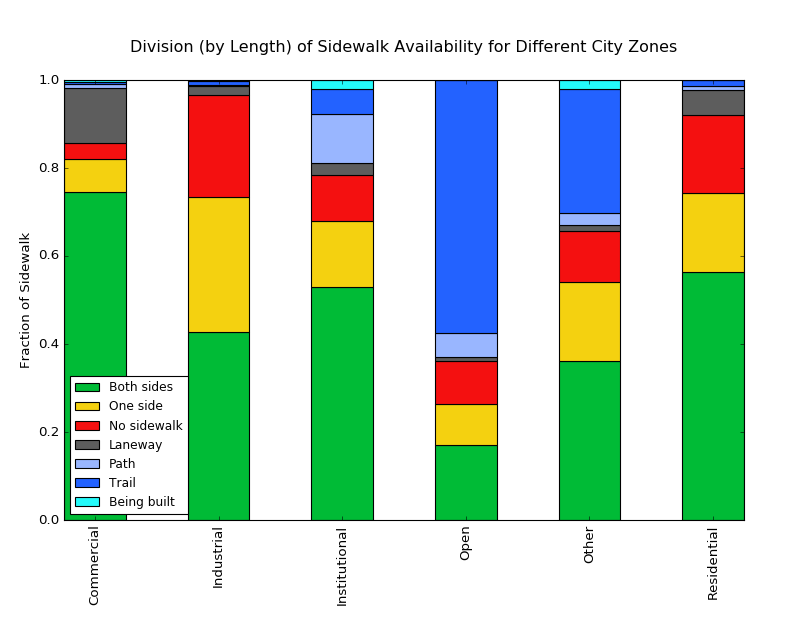

In [164]:
zg = sidewalk.groupby(["Zone Category", "Sidewalk Status"])

# Length of sidewalks of varying statuses, normalized by total sidewalk length
# Unstack to produce pivot table from multi-index
frac_side = ( zg["Shape_Leng"].sum()/zg["Shape_Leng"].sum().sum(level=0) ).unstack()

length = 10; height = 8; barwidth = 0.5
fig = plt.figure(figsize=(length, height))
ax = fig.add_axes([0.8/length, 1.5/height, 8.5/length, 5.5/height])
ind = np.arange(frac_side.index.shape[0])
fs_terms = ["both", "one", "no", "laneway", "path", "trail", "being built"]
labels = ["Both sides", "One side", "No sidewalk", "Laneway", "Path", "Trail", "Being built"]
counter = 0
for i in range(len(fs_terms)):
    ax.bar(ind, frac_side[fs_terms[i]], width=barwidth, label=labels[i], color=plot_colours[fs_terms[i]],
          bottom=counter)
    counter += frac_side[fs_terms[i]]

ax.set_xticks([i + barwidth/2 for i in ind])
ax.set_xticklabels(frac_side.index, rotation='vertical')
ax.set_xlim([0, 5. + barwidth]); ax.set_ylim([0, 1.0]); ax.set_ylabel("Fraction of Sidewalk"); ax.set_xlabel("")
ax.set_title("Division (by Length) of Sidewalk Availability for Different City Zones", y=1.05);
ax.legend(loc=3, fontsize=11);

Unsurprising that about 75% of commerical streets have sidewalks on both sides, while industrial streets have both, one or no sidewalks in roughly equal proportion.  Open and institutional areas are parks, universities, golf courses, etc, and so it is also unsurprising that many of their roads have limited sidewalk availability (and many of their roads are actually paths, trails and walkways).  Somewhat surprising that around 40% of residential streets have sidewalks on only one side, or none at all.

<h2>Correlation with Ward Median Income</h2>

I obtain the 2010 median household income from each ward from the 2011 National Households Survey data in the [Ward Profiles dataset](http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=71d9c7e6e34b6410VgnVCM10000071d60f89RCRD).  We can then plot maps of ward income compared to sidewalk availability.

I define the "fraction of missing sidewalk" or "fraction of roads without sidewalk" as 

```frac_wg["missing"] = frac_wg["no"] / (  frac_wg["both"] + frac_wg["one"] + frac_wg["no"] )```

This definition doesn't include laneways, paths, etc., since these don't include sidewalks, or are purely pedestrian paths, by design.  It also assumes that having sidewalks on only one side of the road is sufficient for availability.

In [139]:
income = pd.read_csv("WardMedianIncome.csv", skiprows=1, index_col=0).T

wg = sidewalk.groupby(["ward", "Sidewalk Status"])
frac_wg = wg["Shape_Leng"].sum().unstack().fillna(0)
frac_wg.set_index(income.index, inplace=True)

frac_wg["Mean Income Scaled"] = income["Average household total income $"]/10000.
frac_wg["Median Income Scaled"] = income["Median household total income $"]/10000.
frac_wg["Mean One-Person Income Scaled"] = income['Average one-person private household total income $']/10000.
frac_wg["Median One-Person Income Scaled"] = income['Median one-person private household total income $']/10000.
frac_wg["LIM-AT"] = income['Prevalence of low income in 2010 based on after-tax low-income measure %']

frac_wg = gpd.GeoDataFrame(frac_wg)
ward_bds_ser = pd.Series(ward_bds) ; ward_bds_ser.index = frac_wg.index
frac_wg["geometry"] = ward_bds_ser
# total sidewalk, not counting those under construction, laneways, etc.
frac_wg["tot"] = frac_wg["both"] + frac_wg["one"] + frac_wg["no"]
frac_wg["missing"] = frac_wg["no"] / frac_wg["tot"] * 100 #(frac_wg["one"] + frac_wg["no"]) / frac_wg["tot"]

<IPython.core.display.Javascript object>


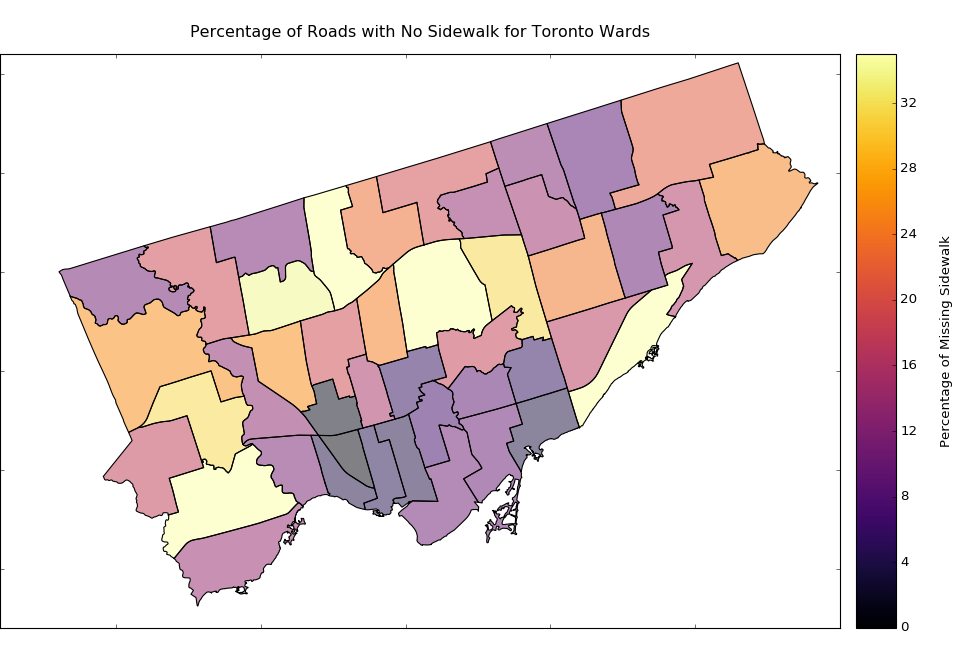

<IPython.core.display.Javascript object>


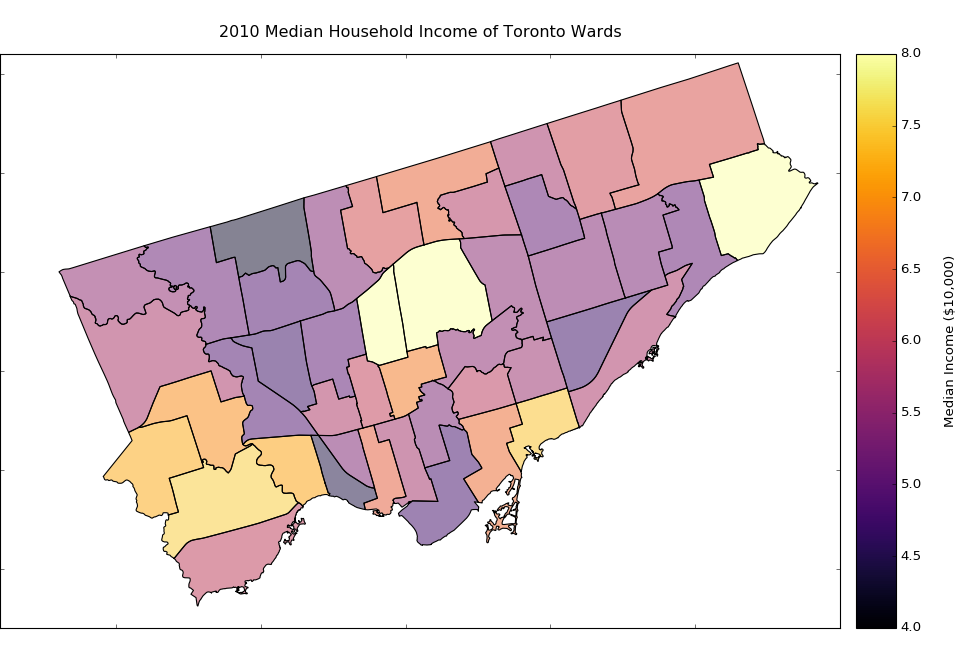

In [198]:
# Simpler way of doing it than using cartopy, and possible because it's such a small non-polar area that 
# there's little Plate-Carree distortion

# http://stackoverflow.com/questions/36008648/colorbar-on-geopandas
fig = plt.figure(figsize=(12, 8.2))
ax = fig.add_axes([0., 0.3/7., 10.5/12, 7./8.])
cbar = fig.add_axes([10.7/12, 0.3/7., 0.5/12, 7./8.])
frac_wg.plot("missing", ax=ax, cmap='inferno', vmin=0, vmax=35.); 
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=35.))
sm._A = []
cb = fig.colorbar(sm, cax=cbar)
cb.set_label("Percentage of Missing Sidewalk", labelpad=20)
ax.set_xlim([-79.68, -79.1]); ax.set_ylim([43.57, 43.86]); ax.set_xticklabels([]);
ax.set_title("Percentage of Roads with No Sidewalk for Toronto Wards", y=1.02);

fig = plt.figure(figsize=(12, 8.2))
ax = fig.add_axes([0., 0.3/7., 10.5/12, 7./8.])
cbar = fig.add_axes([10.7/12, 0.3/7., 0.5/12, 7./8.])
frac_wg.plot("Median Income Scaled", ax=ax, cmap='inferno', vmin=4, vmax=8.); 
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=4, vmax=8.))
sm._A = []
cb = fig.colorbar(sm, cax=cbar)
cb.set_label("Median Income ($10,000)", labelpad=20)
ax.set_xlim([-79.68, -79.1]); ax.set_ylim([43.57, 43.86]); ax.set_xticklabels([]);
ax.set_title("2010 Median Household Income of Toronto Wards", y=1.02);

There doesn't appear to be any kind of correlation, even if you ignore the downtown core where households are in apartments rather than detached homes.  We can directly plot median income against percentage of missing sidewalk.

<IPython.core.display.Javascript object>


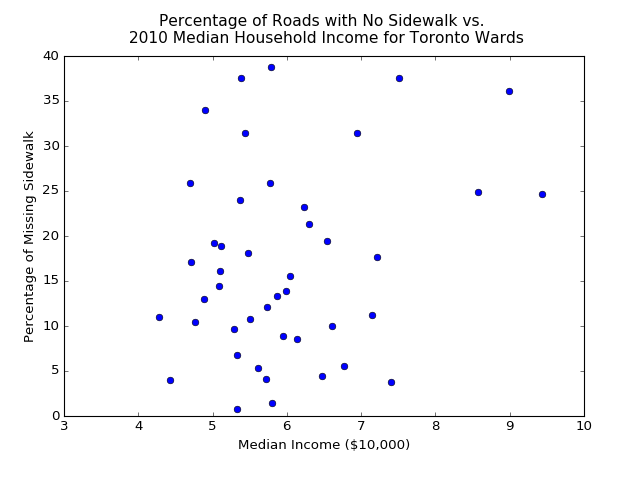

In [197]:
length = 8; height = 6;
fig = plt.figure(figsize=(length,height))

ax = fig.add_axes([0.8/length, 0.8/height, 6.5/length, 4.5/height])
ax.plot(frac_wg["Median Income Scaled"], frac_wg["missing"], 'bo')
ax.set_xlim([3,10]);ax.set_ylim([0,40]);
ax.set_ylabel("Percentage of Missing Sidewalk", labelpad=5)
ax.set_xlabel("Median Income ($10,000)", labelpad=5)
ax.set_title("Percentage of Roads with No Sidewalk vs. \n 2010 Median Household Income for Toronto Wards", y=1.02, fontsize=14);

There is no correlation.

The 2011 NHS data also includes [one-person household income](https://unstats.un.org/unsd/demographic/sconcerns/fam/fammethods.htm) (which includes both single people and those with dependents), which is a rough measure of per-provider income, and the [fraction of individuals](http://www12.statcan.gc.ca/nhs-enm/2011/ref/dict/fam025-eng.cfm) within the ward that fall below the [Low-Income Measure After Tax (LIM-AT)](http://www12.statcan.gc.ca/nhs-enm/2011/ref/dict/fam021-eng.cfm).  We can also check if sidewalk availability correlates with either measure.

<IPython.core.display.Javascript object>


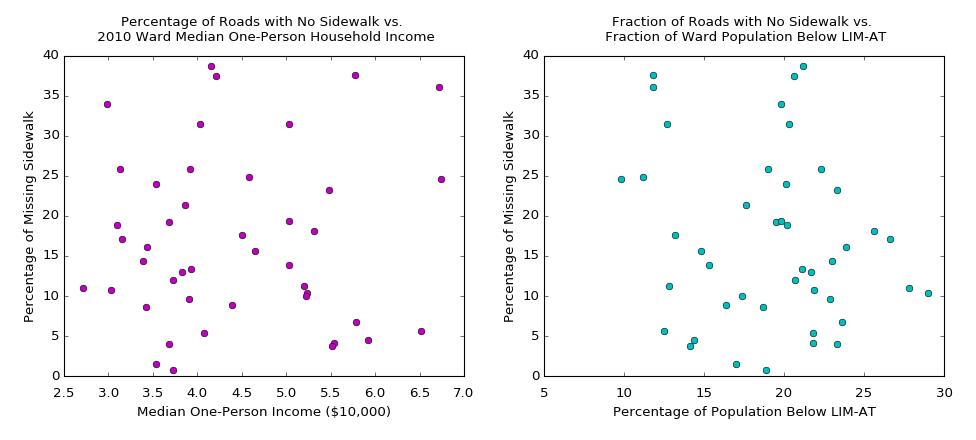

In [199]:
length = 12.2; height = 5.5;

fig = plt.figure(figsize=(length,height))

ax1 = fig.add_axes([0.8/length,0.8/height, 5.0/length, 4.0/height])
ax1.plot(frac_wg["Mean One-Person Income Scaled"], frac_wg["missing"], 'mo')
ax1.set_xlabel("Median One-Person Income ($10,000)", labelpad=5)
ax1.set_ylabel("Percentage of Missing Sidewalk", labelpad=5)
ax1.set_title("Percentage of Roads with No Sidewalk vs. \n 2010 Ward Median One-Person Household Income", y=1.03, fontsize=12);
ax1.tick_params(axis='x', pad=10);

ax2 = fig.add_axes([6.8/length,0.8/height, 5.0/length, 4.0/height])
ax2.plot(frac_wg["LIM-AT"], frac_wg["missing"], 'co')
ax2.set_xlabel("Percentage of Population Below LIM-AT", labelpad=5)
ax2.set_ylabel("Percentage of Missing Sidewalk", labelpad=5)
ax2.set_title("Fraction of Roads with No Sidewalk vs. \n Fraction of Ward Population Below LIM-AT", y=1.03, fontsize=12);
ax2.tick_params(axis='x', pad=10);

There aren't any correlations with these indicators either.

<h2>Correlation with Population Density</h2>

Lastly, I check if the fraction of missing sidewalk is inversely proportional to population density, which is to be expected since life in a dense urban neighbourhood is not conducive to car use.  We can obtain density by dividing 2010 ward population, available in the Ward Profiles - Census_2011.xlsx file from the Ward Profiles dataset, by ward area, available in the Ward Profiles - WardAreas.xlsx file.

In [200]:
pop2010 = pd.read_csv("WardTotalPop.csv", skiprows=1, index_col=0).T
wardareas = pd.read_excel("data/Ward Profiles - WardAreas.xlsx", skiprows=7, skipfooter=8, index_col=0)
wardareas.index = pop2010.index
frac_wg["Population Density (pop/km^2)"] = pop2010["Total population"]/wardareas["Area (sq km)"]

<IPython.core.display.Javascript object>


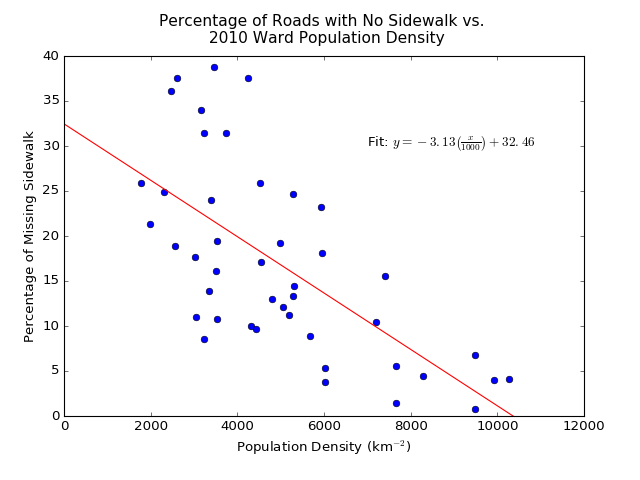

/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [202]:
length = 8; height = 6;
fig = plt.figure(figsize=(length,height))

ax = fig.add_axes([0.8/length, 0.8/height, 6.5/length, 4.5/height])
ax.plot(frac_wg["Population Density (pop/km^2)"], frac_wg["missing"], 'bo')
ax.set_xlim([0,12000]);ax.set_ylim([0,40]);
bestfit = np.polyfit(frac_wg["Population Density (pop/km^2)"], frac_wg["missing"], 1)
xdumm = np.linspace(0,12000,10.)
ax.plot(xdumm, bestfit[0]*xdumm + bestfit[1], 'r-')
ax.text(7e3, 30., "Fit: $y = {0:.2f}\\left(\\frac{{x}}{{1000}}\\right) + {1:.2f}$".format(bestfit[0]*1000, bestfit[1]))
ax.set_ylabel("Percentage of Missing Sidewalk", labelpad=5)
ax.set_xlabel(r"Population Density (km$^{{-2}}$)", labelpad=5)
ax.set_title("Percentage of Roads with No Sidewalk vs. \n 2010 Ward Population Density", y=1.02, fontsize=14);

As expected, a correlation exists, albiet with significant scatter about the best-fit line.  This correlation isn't necessarily causal - downtown Toronto has a high population density, but also features extensive commercial, financial and business areas (Queen, King, Yonge, Yorkville, etc.) that must cater to pedestrian traffic to function.

<h1>Conclusions</h1>

Some conclusions from this analysis:

- Visual inspection of the plot of all sidewalk availability indicates sidewalks are least available in the municipalities outside of Toronto.
- Subdividing the inventory by city zoning, we find that commercial zones have the highest fraction (by length) of streets with sidewalks available on both sides, followed by residential and institutional zones.  Industrial zones and open spaces have comparatively poor sidewalk coverage, which is to be expected from the lack of pedestrian traffic in the former and the availability of paths and trailways in the latter.
- There's an inverse correlation between population density and percentage of streets without any sidewalk.  This is to be expected, since densely populated residences disproportionately need sidewalks for foot traffic, and dense urban areas also have commercial and business centres that need pedestrian access.
- There's no correlation between the percentage of streets without any sidewalk in a ward and its 2010 median household income, median one-person household income or fraction of the population below its Low-Income Measure After Tax.  It may still be the case that lower-income neighbourhoods of the same type (detached homes or apartments) or same population density are not as well serviced.

Further Work:

- Subdivision of residences into detached housing, condos, townhouses, etc., will allow us to isolate detached home neighbourhoods from ones dominated by apartments and condos.  It would be interesting to consider whether lower-income suburban neighbourhoods have less sidewalk availability than higher-income ones.
- If I can find a high-quality dataset of detached home prices, I could supplement the income correlation analysis above with house price.
- Simply looking at areas lacking sidewalks doesn't indicate whether sidewalks are actually needed for these streets, or the urgency with which they're needed.  This could be determined by looking at pedestrian traffic (or petitions for sidewalk expansion).  Moreover, having sidewalks available doesn't mean the sidewalks aren't in some state of disrepair.  Perhaps a future inventory could include some kind of quality index.